In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import graphviz
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import os
import numpy as np
import pandas as pd
import graphviz
from IPython.display import Image
from difflib import SequenceMatcher
pd.options.mode.chained_assignment = None

In [ ]:
filenames = next(os.walk("./"), (None, None, []))[2]
anion_file_name = None
cation_file_name = None
if len(filenames) == 0:
  raise BaseException("No files were imported.")
for f in filenames:
  if "Anionic-Cationic" in f:
    anion_file_name = f
    cation_file_name = f
    break
  elif "Anionic" in f:
    anion_file_name = f
  elif "Cationic" in f:
    cation_file_name = f

if anion_file_name is None or cation_file_name is None:
    raise BaseException("Do the name of the files follow the following convention, such that it should contain 'Anionic-Cationic', 'Anionic' or 'Cationic'")

if anion_file_name == cation_file_name:
  a = int(input("Do you wish to run the experiments on both the cations and anions at the same time ? (Enter 1 to continue) "))
  if a != 1:
    anion_file_name = None
    cation_file_name = None
    raise BaseException("Automatically getting file names did not work.\nThere appears to be a file that contains 'Anionic-Cationic' in its name.")
else:
  a = int(input("Do you wish to use the following file with anions ? "+ anion_file_name+ " (Enter 1 to continue) "))
  b = int(input("Do you wish to use the following file with cations ? "+ cation_file_name+ " (Enter 1 to continue) "))
  if a != 1 or b != 1:
    raise BaseException("Automatically getting file names did not work.\n There seems to be multiple filenames that contain 'Anionic' or 'Cationic'")

Vous souhaitez utiliser le fichier suivant pour les anions ? Anionic_16_membranes_VF.csv (Entrez 1 pour continuer) 1
Vous souhaitez utiliser le fichier suivant pour les cations ? Cationic_16_membranes_VF.csv (Entrez 1 pour continuer) 1


In [ ]:
DEPTH = int(input("What tree depth would you like ?" ))
if DEPTH < 1:
  raise BaseException("The depth entered is invalid. Please choose a positive number.")

nbr_me = int(input("Does your file contain 14 or 16 membranes ?"))
if nbr_me == 14:
  DECALAGE = False
else:
  nbr_membranes = int(input("How many membranes do you wish to use ? (14 or 16)"))
  if nbr_membranes == 16:
    DECALAGE = False
  elif nbr_membranes == 14:
    DECALAGE = True
  else:
    raise BaseException("The number of membranes entered is invalid. Please choose 14 or 16 membranes. ")

Quelle est la profondeur des arbres qui vous intéresse ? 4
Est-ce que votre fichier contient 14 ou 16 membranes ?16
Quel est le nombre de membranes qui vous intéresse ? (14 ou 16)14


In [ ]:
### DATALOADER

decalage = np.array([34, 22])
decalage_full = 56
is_equal = (anion_file_name == cation_file_name)

anion_file_name = "./" + anion_file_name
cation_file_name = "./" + cation_file_name

def load_data(boolean):
    if boolean:
      df = pd.read_csv(cation_file_name, sep=";")
    else:
      df = pd.read_csv(anion_file_name, sep=";")

    if DECALAGE:
      s = df.shape[0]
      df = df.iloc[DECALAGE*(decalage[int(boolean)]*(1-int(is_equal))+ decalage_full*int(is_equal)):, :]


    l = ['R1 A-', 'R2 A-', 'R3 A-', 'R1 C+', 'R2 C+', 'R3 C+']
    y = df[l]
    y.rename(columns={'R1 A-': 'R1_A', 'R2 A-': 'R2_A',
                      'R3 A-': 'R3_A', 'R1 C+': 'R1_C',
                      'R2 C+': 'R2_C', 'R3 C+': 'R3_C'},
             inplace=True)
    l = l + ['membrane', 'Peptides', 'bend_percent', 'turn_percent']
    df = df.drop(columns=l)
    return df, y

def load_data_mean(boolean):
    """
    Returns the data. We take the mean of the response variable.
    :param boolean: True if we want positive data, False otherwise.  
    :return:
    """
    df, y = load_data(boolean)
    if boolean:
        y_pos = y[['R1_C', 'R2_C', 'R2_C']].mean(axis=1)
        return df, y_pos
    else:
        y_neg = y[['R1_A', 'R2_A', 'R3_A']].mean(axis=1)
        return df, y_neg

def get_peptides_names(boolean):
      if boolean:
        df = pd.read_csv(cation_file_name, sep=";")
      else:
        df = pd.read_csv(anion_file_name, sep=";")

      if DECALAGE:
        df = df.iloc[DECALAGE*(decalage[int(boolean)]*(1-int(is_equal))+ decalage_full*int(is_equal)):, :]
      return (df['membrane'] + ' + ' + df['Peptides'])

def get_features(X, y, threshold):
  regressor = RandomForestRegressor(random_state=1, n_estimators=1000)
  regressor.fit(X, y)
  feat_importance = pd.DataFrame(regressor.feature_importances_.T, index=X_selected.columns).sort_values(by=0,
                                                                                                        ascending=False)
  new_indexs_pos = feat_importance[feat_importance[0] > threshold].index
  return new_indexs_pos, feat_importance

def get_decisions(X, y):
    regressor = DecisionTreeRegressor(random_state=1, max_depth=DEPTH, criterion='squared_error')
    parameters = {'min_samples_split':[2,3,4,5,6],
                  'min_samples_leaf':[2,3,4,5,6]}
    clf = GridSearchCV(regressor, parameters)
    clf.fit(X, y)

    mean_test_score = clf.cv_results_['mean_test_score']
    std_test_score = clf.cv_results_['std_test_score']

    clf1 = DecisionTreeRegressor(random_state=1,
                                 criterion='squared_error',
                                 max_depth=DEPTH,
                                 min_samples_split=clf.best_params_['min_samples_split'],
                                 min_samples_leaf=clf.best_params_['min_samples_leaf'])
    clf1.fit(X, y)
    leaves = clf1.apply(X)
    prediction = clf1.predict(X)

    r2_score = clf1.score(X, y)
    print("The R^2 of the tree is : ", r2_score)
    return leaves, prediction, clf1

def print_tree(clf, feature_name, file_name):
    dot_data = tree.export_graphviz(clf, out_file=None,
                            feature_names=feature_name,
                            filled=True, rounded=True,
                            special_characters=True, rotate=True, leaves_parallel=True)

    graph = graphviz.Source(dot_data)
    graph.dpi = 500
    graph.size = "30,30!"
    graph.render(file_name, format='jpg')
    os.remove(file_name)

# cation 0.02


In [ ]:
anion_cation = True
threshold = 0.02

print("Results for the experiments with {'cations' if anion_cation else 'anions} and a threshold of {threshold}")

membrane = ['Contact angle', 'hydrophilic pores',
        'Volumetric porosity', 'Zeta-potential', 'Rz', ' Macropores FL']

peptide = ['mol_weight', 'isoelectric_point',
        'GRAVY', 'm/z_at_pH7.0',
        'Hall Kier Alpha', 'Polar R', 'A', 'D', 'F', 'H',
        'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

features = membrane + peptide

X, y = load_data_mean(anion_cation)
X_selected = X[features]
selected_features, feat_importance = get_features(X_selected, y, threshold)
print("Selected features : " , list(selected_features))
feat_importance

Données pour l'expérience avec les cations et le seuil de 0.02
Selected features :  ['Rz', 'isoelectric_point', 'mol_weight', 'm/z_at_pH7.0', ' Macropores FL', 'A']


,0
Rz,0.452548
isoelectric_point,0.287409
mol_weight,0.063137
m/z_at_pH7.0,0.045054
Macropores FL,0.039499
A,0.020471
Hall Kier Alpha,0.011886
L,0.010495
Y,0.009057
K,0.008808


Le r^2 de l'arbre est :  0.8218489433877315


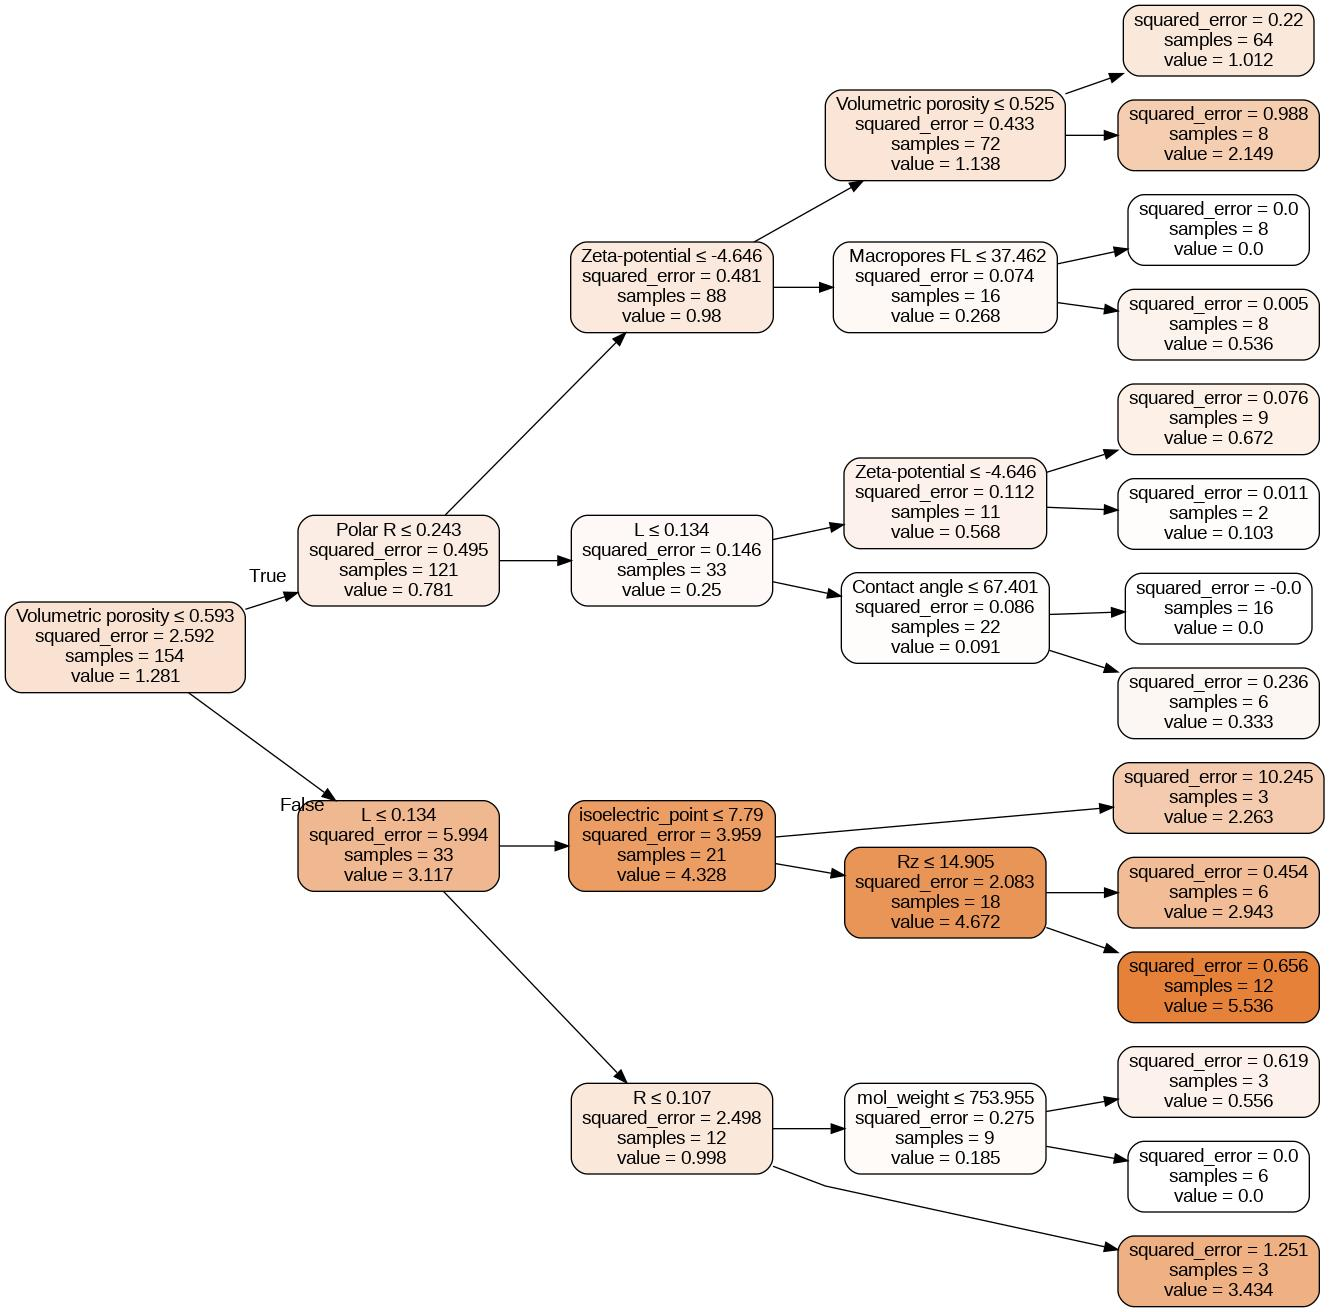

In [ ]:
X_new = X_selected[selected_features]
leaves, prediction, clf = get_decisions(X_new, y)
print_tree(clf, selected_features, f"tree_{anion_cation}_{threshold}_{DEPTH}_{nbr_membranes}")
Image(f"tree_{anion_cation}_{threshold}_{DEPTH}_{nbr_membranes}.jpg")

In [ ]:
df_prediction = pd.DataFrame(prediction[np.argsort(leaves)], index=get_peptides_names(anion_cation)[DECALAGE*(decalage[int(anion_cation)]*(1-int(is_equal))+ decalage_full*int(is_equal)) + np.argsort(leaves)], columns=["Prédiction"])
df_x = pd.DataFrame(X_new.iloc[np.argsort(leaves), :])
df_x.index = df_prediction.index
# pd.concat([df_x, df_prediction], axis=1)
df_y = pd.DataFrame(y[DECALAGE*(decalage[int(anion_cation)]*(1-int(is_equal))+ decalage_full*int(is_equal))+np.argsort(leaves)], columns=['target'])
df_y.index = df_prediction.index
pd.concat([df_x, df_prediction, df_y], axis=1)

,Volumetric porosity,L,m/z_at_pH7.0,Polar R,Rz,V,R,Zeta-potential,Macropores FL,mol_weight,Contact angle,hydrophilic pores,isoelectric_point,Prédiction,target
PES30 + TKIPAVF,0.516739,0.000000,781.239098,0.142857,7.364167,0.142857,0.000000,-17.386667,11.571342,774.961,58.939820,56.817181,8.410110,1.011645,0.891353
PES50 + TKIPAVFK,0.515744,0.000000,453.424742,0.125000,9.044333,0.125000,0.000000,-13.428900,17.540630,903.136,79.166667,83.715125,10.000545,1.011645,1.083690
PES50 + IPAVFK,0.515744,0.000000,675.363384,0.000000,9.044333,0.166667,0.000000,-13.428900,17.540630,673.856,79.166667,83.715125,8.750052,1.011645,0.898924
PES50 + ALPHMIR,0.515744,0.142857,763.194626,0.000000,9.044333,0.000000,0.142857,-13.428900,17.540630,837.062,79.166667,83.715125,9.800371,1.011645,0.896009
PES50 + PMHIR,0.515744,0.000000,594.246070,0.000000,9.044333,0.000000,0.200000,-13.428900,17.540630,652.823,79.166667,83.715125,10.180928,1.011645,0.891153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S11SO3- + ALPMHIRLSFNPTQ,0.655407,0.142857,1481.540073,0.285714,23.866333,0.000000,0.071429,-5.791800,27.158006,1624.934,36.000000,99.322643,9.800371,0.000000,0.000000
S11 + YKKYLL,0.667620,0.333333,415.534864,0.333333,21.707000,0.000000,0.000000,-7.438767,25.817083,827.037,34.500000,97.383049,9.528250,0.000000,0.000000
S11SO3- + ALPHMIR,0.655407,0.142857,763.194626,0.000000,23.866333,0.000000,0.142857,-5.791800,27.158006,837.062,36.000000,99.322643,9.800371,3.434348,4.337921
PES300 + ALPHMIR,0.599385,0.142857,763.194626,0.000000,8.102167,0.000000,0.142857,-11.183333,88.469525,837.062,62.492086,88.986728,9.800371,3.434348,1.858200


In [ ]:
pd.concat([df_x, df_prediction, df_y], axis=1).to_csv("cation_0.02.csv")

#cation 0.05

In [ ]:
anion_cation = True
threshold = 0.05

print("Results for the experiments with {'cations' if anion_cation else 'anions} and a threshold of {threshold}")

membrane = ['Contact angle', 'hydrophilic pores',
        'Volumetric porosity', 'Zeta-potential', 'Rz', ' Macropores FL']

peptide = ['mol_weight', 'isoelectric_point',
        'GRAVY', 'm/z_at_pH7.0',
        'Hall Kier Alpha', 'Polar R', 'A', 'D', 'F', 'H',
        'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

features = membrane + peptide

X, y = load_data_mean(anion_cation)
X_selected = X[features]
selected_features, feat_importance = get_features(X_selected, y, threshold)
print("Selected features : ", selected_features)
feat_importance

Données pour l'expérience avec les cations et le seuil de 0.05
Selected features :  Index(['Volumetric porosity', 'L', 'm/z_at_pH7.0'], dtype='object')


,0
Volumetric porosity,0.395306
L,0.151367
m/z_at_pH7.0,0.090195
Polar R,0.036215
Rz,0.036078
V,0.035049
R,0.030262
Zeta-potential,0.027834
Macropores FL,0.025524
mol_weight,0.025518


Le r^2 de l'arbre est :  0.7107313482366788


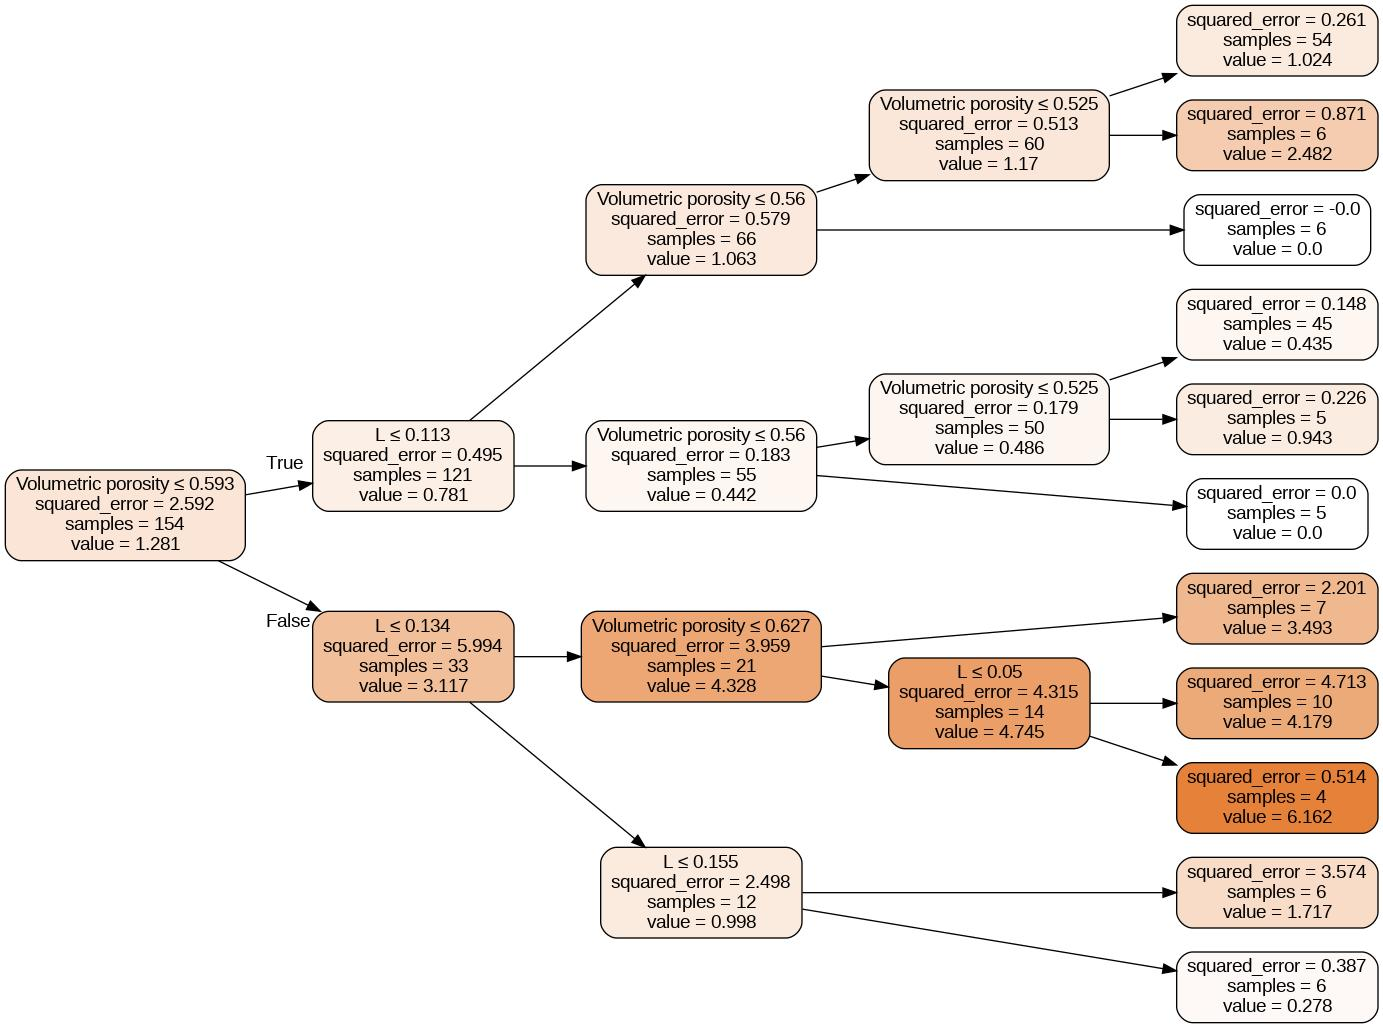

In [ ]:
X_new = X_selected[selected_features]
leaves, prediction, clf = get_decisions(X_new, y)
print_tree(clf, selected_features, f"tree_{anion_cation}_{threshold}_{DEPTH}_{nbr_membranes}")
Image(f"tree_{anion_cation}_{threshold}_{DEPTH}_{nbr_membranes}.jpg")

In [ ]:
df_prediction = pd.DataFrame(prediction[np.argsort(leaves)], index=get_peptides_names(anion_cation)[DECALAGE*(decalage[int(anion_cation)]*(1-int(is_equal))+ decalage_full*int(is_equal)) + np.argsort(leaves)], columns=["Prédiction"])
df_x = pd.DataFrame(X_new.iloc[np.argsort(leaves), :])
df_x.index = df_prediction.index
# pd.concat([df_x, df_prediction], axis=1)
df_y = pd.DataFrame(y[DECALAGE*(decalage[int(anion_cation)]*(1-int(is_equal))+ decalage_full*int(is_equal))+np.argsort(leaves)], columns=['target'])
df_y.index = df_prediction.index
pd.concat([df_x, df_prediction, df_y], axis=1)

,Volumetric porosity,L,m/z_at_pH7.0,Prédiction,target
PES30 + TKIPAVF,0.516739,0.000000,781.239098,1.024033,0.891353
PES50 + PMHI,0.515744,0.000000,5037.624734,1.024033,0.657538
PES50 + TKIPAVFK,0.515744,0.000000,453.424742,1.024033,1.083690
PES50 + IPAVFK,0.515744,0.000000,675.363384,1.024033,0.898924
PES50 + PMHIR,0.515744,0.000000,594.246070,1.024033,0.891153
...,...,...,...,...,...
PES300 + YKKYLL,0.599385,0.333333,415.534864,0.278128,0.000000
S11 + ALPMHI,0.667620,0.166667,7033.920887,0.278128,0.000000
S11SO3- + YKKYLL,0.655407,0.333333,415.534864,0.278128,0.000000
S11SO3- + ALPMHI,0.655407,0.166667,7033.920887,0.278128,0.000000


# anion 0.02

In [ ]:
anion_cation = False
threshold = 0.02

print("Results for the experiments with {'cations' if anion_cation else 'anions} and a threshold of {threshold}")

membrane = ['Contact angle', 'hydrophilic pores',
        'Volumetric porosity', 'Zeta-potential', 'Rz', ' Macropores FL']

peptide = ['mol_weight', 'isoelectric_point',
        'GRAVY', 'm/z_at_pH7.0',
        'Hall Kier Alpha', 'Polar R', 'A', 'D', 'F', 'H',
        'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

features = membrane + peptide

X, y = load_data_mean(anion_cation)
X_selected = X[features]
selected_features, feat_importance = get_features(X_selected, y, threshold)
print("Selected features : ", selected_features)
feat_importance

Données pour l'expérience avec les anions et le seuil de 0.02
Selected features :  Index(['Rz', 'isoelectric_point', 'mol_weight', 'm/z_at_pH7.0',
       ' Macropores FL', 'A'],
      dtype='object')


,0
Rz,0.452548
isoelectric_point,0.287409
mol_weight,0.063137
m/z_at_pH7.0,0.045054
Macropores FL,0.039499
A,0.020471
Hall Kier Alpha,0.011886
L,0.010495
Y,0.009057
K,0.008808


Le r^2 de l'arbre est :  0.8634582235914224


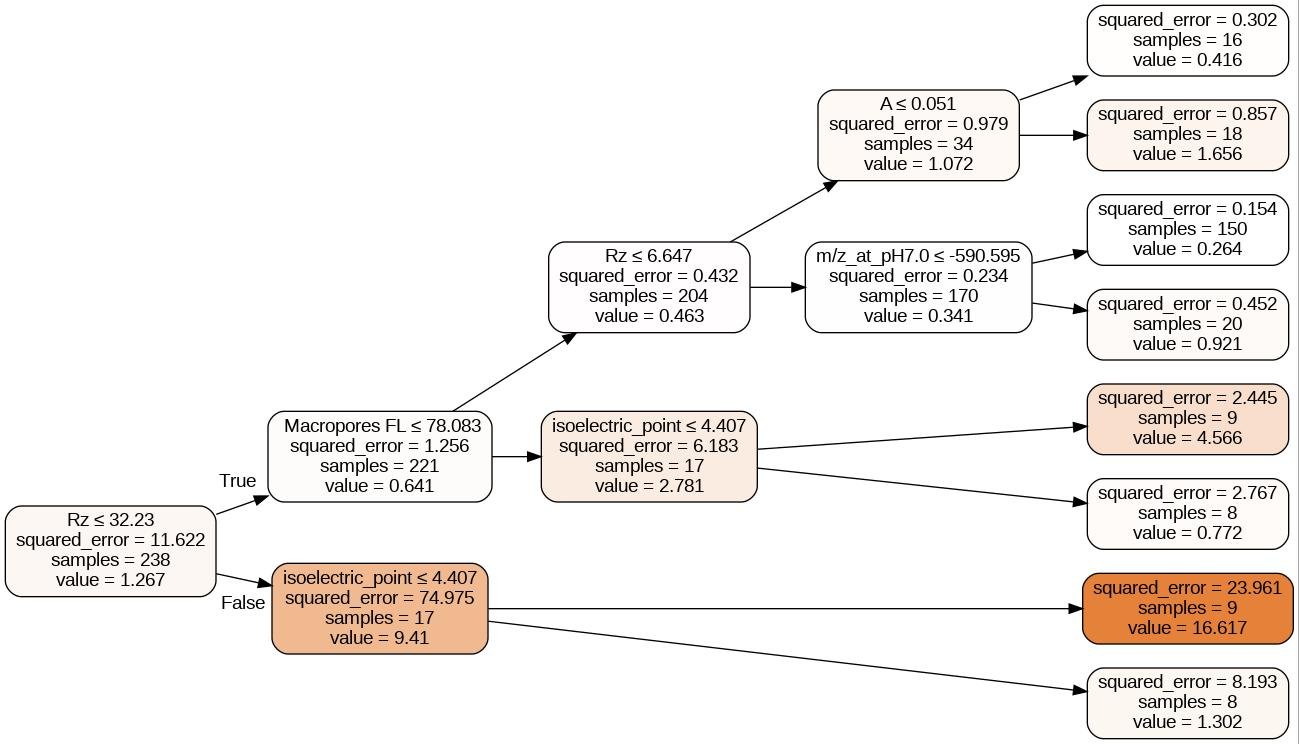

In [ ]:
X_new = X_selected[selected_features]
leaves, prediction, clf = get_decisions(X_new, y)
print_tree(clf, selected_features, f"tree_{anion_cation}_{threshold}_{DEPTH}_{nbr_membranes}")
Image(f"tree_{anion_cation}_{threshold}_{DEPTH}_{nbr_membranes}.jpg")

In [ ]:
df_prediction = pd.DataFrame(prediction[np.argsort(leaves)], index=get_peptides_names(anion_cation)[DECALAGE*(decalage[int(anion_cation)]*(1-int(is_equal))+ decalage_full*int(is_equal)) + np.argsort(leaves)], columns=["Prédiction"])
df_x = pd.DataFrame(X_new.iloc[np.argsort(leaves), :])
df_x.index = df_prediction.index
# pd.concat([df_x, df_prediction], axis=1)
df_y = pd.DataFrame(y[DECALAGE*(decalage[int(anion_cation)]*(1-int(is_equal))+ decalage_full*int(is_equal))+np.argsort(leaves)], columns=['target'])
df_y.index = df_prediction.index
pd.concat([df_x, df_prediction, df_y], axis=1)

,Rz,isoelectric_point,mol_weight,m/z_at_pH7.0,Macropores FL,A,Prédiction,target
PES10 + QSAPLRVYVEELKPTPEGDL,5.482500,4.407318,2241.530,-1.119476e+03,10.023825,0.050000,0.415607,0.000000
PES100 + EQLTK,5.928833,6.100722,617.701,-1.222450e+06,26.999303,0.000000,0.415607,0.000000
PES100 + VLVLDTDYKK,5.928833,5.929580,1193.408,-5.669781e+05,26.999303,0.000000,0.415607,0.518696
PES10 + VLVLDTDYKK,5.482500,5.929580,1193.408,-5.669781e+05,10.023825,0.000000,0.415607,0.000000
PES10 + GLDIQK,5.482500,5.835682,672.781,-3.488261e+05,10.023825,0.000000,0.415607,0.449765
...,...,...,...,...,...,...,...,...
S11N+ + RLSFNPTQLEE,40.594667,4.856574,1333.466,-1.326205e+03,31.218907,0.000000,1.302428,0.000000
S11N+ + VAGTWY,40.594667,5.494364,695.774,-2.155662e+05,31.218907,0.166667,1.302428,8.733652
S11N+ + IPAVF,40.594667,5.525000,545.681,-2.625765e+05,31.218907,0.200000,1.302428,0.000000
S11N+ + ILDK,40.594667,5.835682,487.598,-3.233306e+05,31.218907,0.000000,1.302428,0.000000


In [ ]:
pd.concat([df_x, df_prediction, df_y], axis=1).to_csv("anion_0.02.csv")
# pd.read_csv("./anion_0.02.csv", index_col=[0] )

# anion 0.05

In [ ]:
anion_cation = False
threshold = 0.05

print("Results for the experiments with {'cations' if anion_cation else 'anions} and a threshold of {threshold}")

membrane = ['Contact angle', 'hydrophilic pores',
        'Volumetric porosity', 'Zeta-potential', 'Rz', ' Macropores FL']

peptide = ['mol_weight', 'isoelectric_point',
        'GRAVY', 'm/z_at_pH7.0',
        'Hall Kier Alpha', 'Polar R', 'A', 'D', 'F', 'H',
        'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

features = membrane + peptide

X, y = load_data_mean(anion_cation)
X_selected = X[features]
selected_features, feat_importance = get_features(X_selected, y, threshold)
print("Selected features : ", selected_features)
feat_importance

Données pour l'expérience avec les anions et le seuil de 0.05
Selected features :  Index(['Rz', 'isoelectric_point', 'mol_weight'], dtype='object')


,0
Rz,0.452548
isoelectric_point,0.287409
mol_weight,0.063137
m/z_at_pH7.0,0.045054
Macropores FL,0.039499
A,0.020471
Hall Kier Alpha,0.011886
L,0.010495
Y,0.009057
K,0.008808


Le r^2 de l'arbre est :  0.8611237665517538


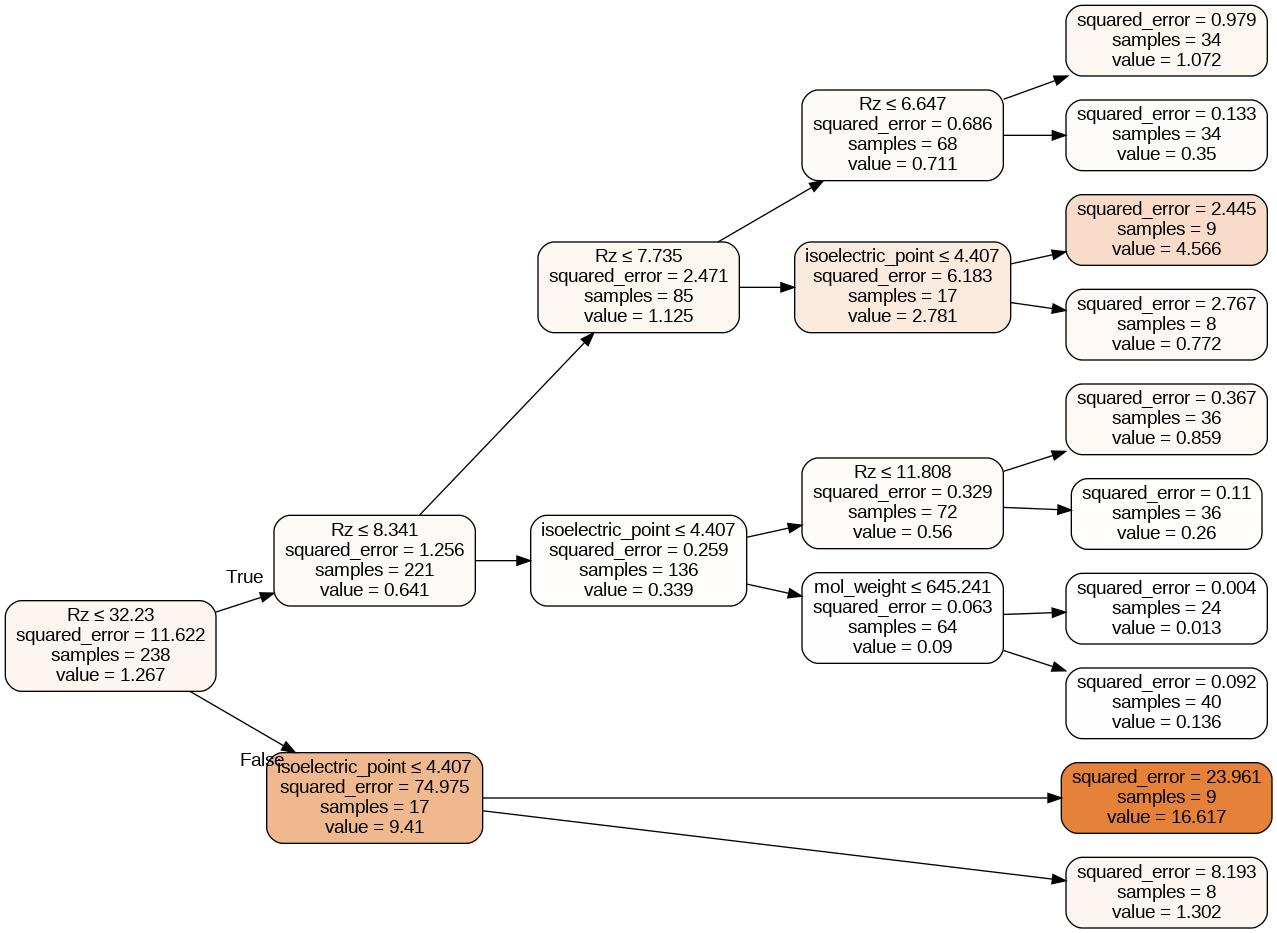

In [ ]:
X_new = X_selected[selected_features]
leaves, prediction, clf = get_decisions(X_new, y)
print_tree(clf, selected_features, f"tree_{anion_cation}_{threshold}_{DEPTH}_{nbr_membranes}")
Image(f"tree_{anion_cation}_{threshold}_{DEPTH}_{nbr_membranes}.jpg")

In [ ]:
df_prediction = pd.DataFrame(prediction[np.argsort(leaves)], index=get_peptides_names(anion_cation)[DECALAGE*(decalage[int(anion_cation)]*(1-int(is_equal))+ decalage_full*int(is_equal)) + np.argsort(leaves)], columns=["Prédiction"])
df_x = pd.DataFrame(X_new.iloc[np.argsort(leaves), :])
df_x.index = df_prediction.index
# pd.concat([df_x, df_prediction], axis=1)
df_y = pd.DataFrame(y[DECALAGE*(decalage[int(anion_cation)]*(1-int(is_equal))+ decalage_full*int(is_equal))+np.argsort(leaves)], columns=['target'])
df_y.index = df_prediction.index
pd.concat([df_x, df_prediction, df_y], axis=1)

,Rz,isoelectric_point,mol_weight,Prédiction,target
PES10 + QSAPLRVYVEELKPTPEGDL,5.482500,4.407318,2241.530,1.072044,0.000000
PES10 + EQLTK,5.482500,6.100722,617.701,1.072044,0.000000
PES10 + ILDK,5.482500,5.835682,487.598,1.072044,0.000000
PES10 + GLDIQK,5.482500,5.835682,672.781,1.072044,0.449765
PES10 + IDALNENK,5.482500,4.370259,916.000,1.072044,1.366430
...,...,...,...,...,...
S11N+ + GLDIQK,40.594667,5.835682,672.781,1.302428,1.685774
S11N+ + IPAVF,40.594667,5.525000,545.681,1.302428,0.000000
S11N+ + VAGTWY,40.594667,5.494364,695.774,1.302428,8.733652
S11N+ + RLSFNPTQLEE,40.594667,4.856574,1333.466,1.302428,0.000000
